# PART 1. FACIAL KEY POINTS DETECTION

###  IMPORT LIBRARIES AND DATASETS

In [1]:
# Import the necessary packages

import pandas as pd
import os
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
#from tensorflow.python.keras import *
from tensorflow.keras import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from google.colab.patches import cv2_imshow

In [57]:
dir_loc = r"E:\DataScience\Udemy\tfc\P96-Section-2-Emotion-AI\Emotion AI"
os.chdir(dir_loc)

In [58]:
# load facial key points data
keyfacial_df = pd.read_csv(os.path.join(dir_loc,'data.csv'))

In [59]:
keyfacial_df.head(2)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  

[2 rows x 31 columns]

In [60]:
# Obtain relavant information about the dataframe
# From Below result we came to know totally we have 15 facial features
# Each Feature contain X and Y coordinates so having, 30 Features
# remaining one feature Image represenatation, all value in between 0 to 255
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [61]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [62]:
keyfacial_df['Image'].shape

(2140,)

In [63]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [64]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [65]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

In [66]:
# TASK #3: PERFORM IMAGE VISUALIZATION

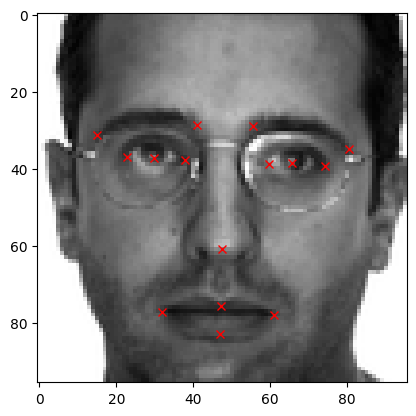

In [67]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


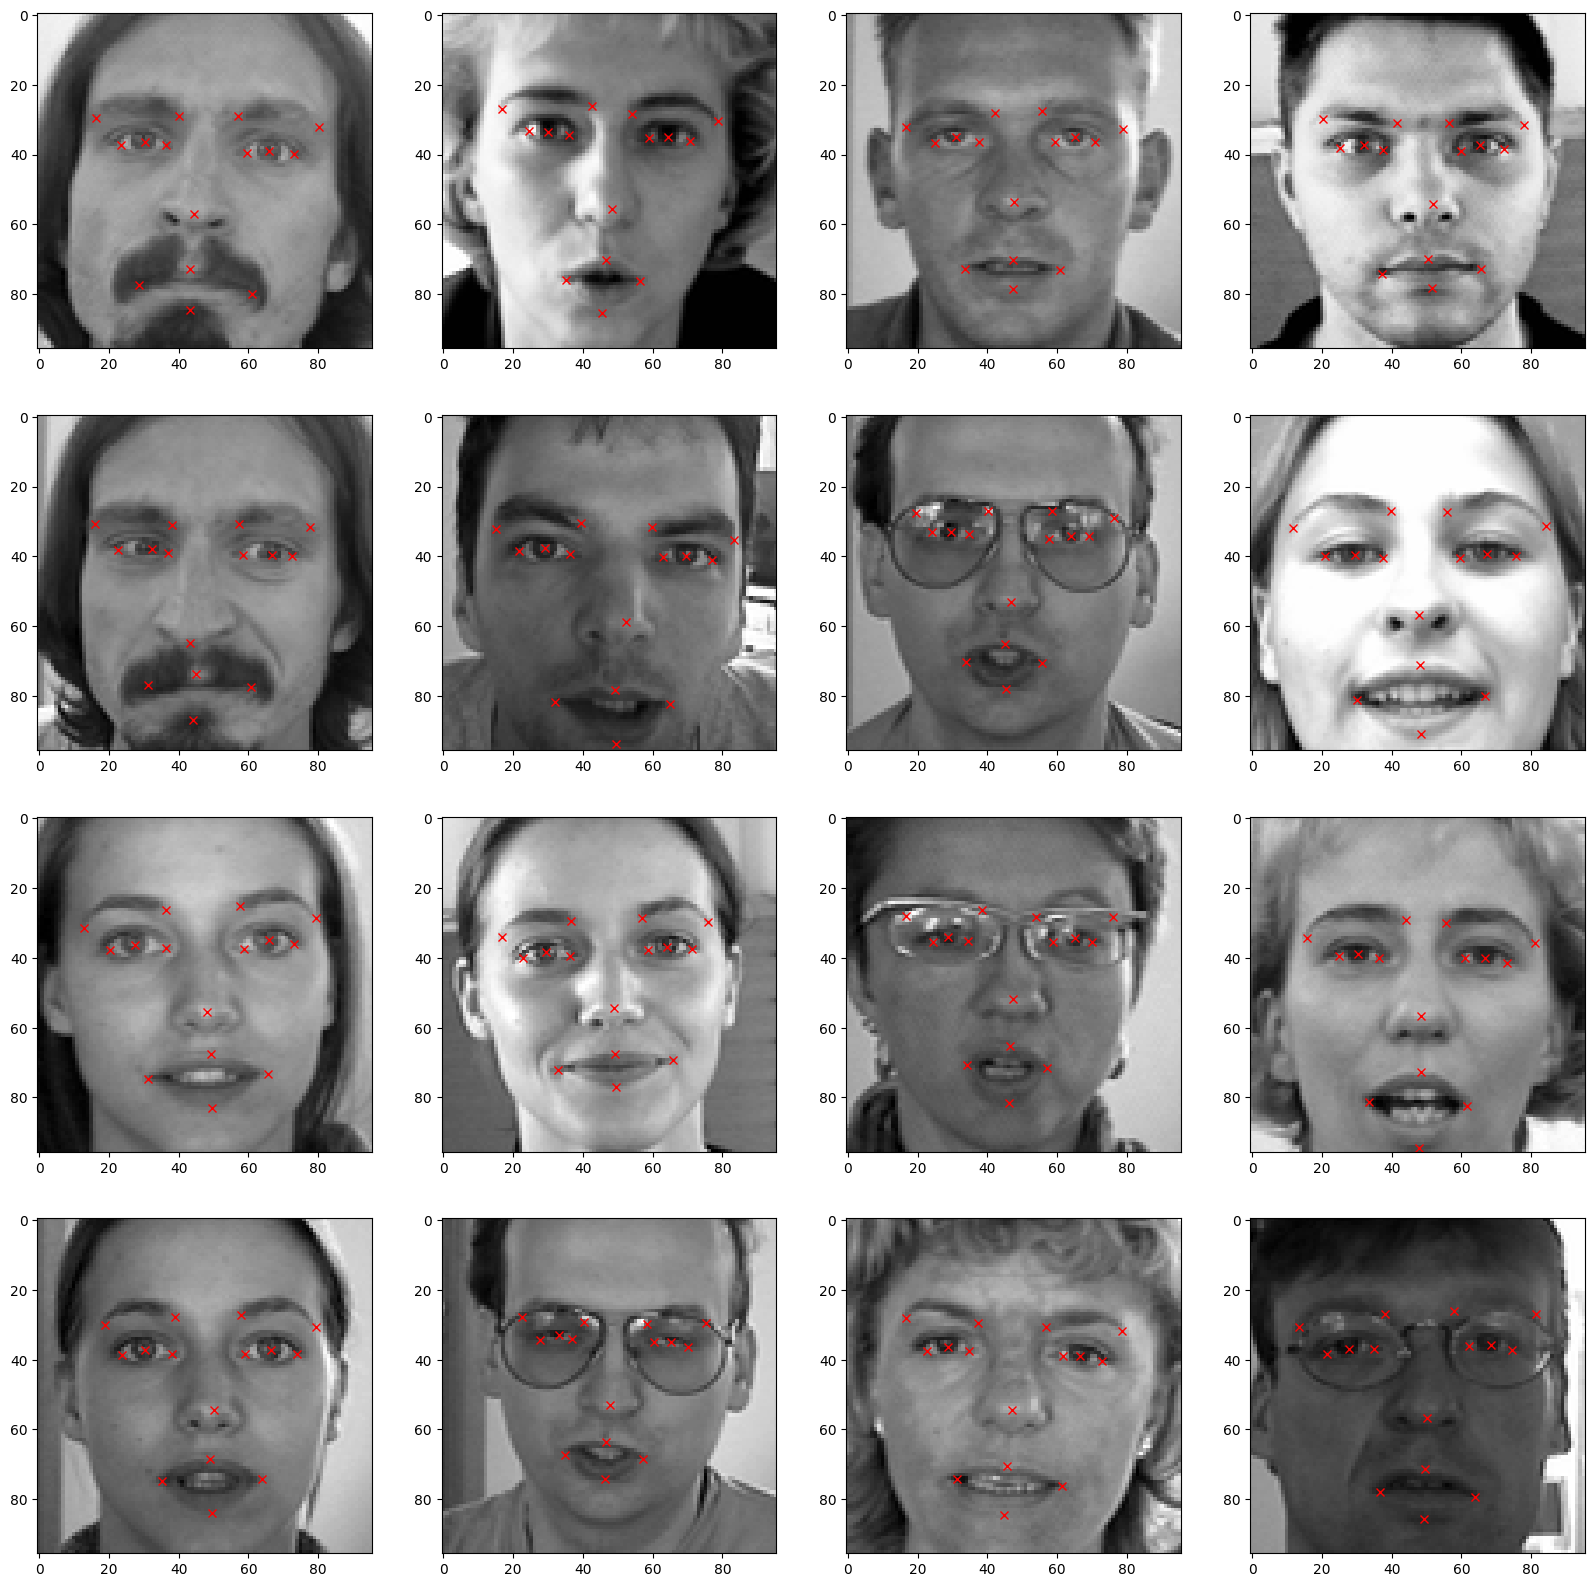

In [68]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')
    

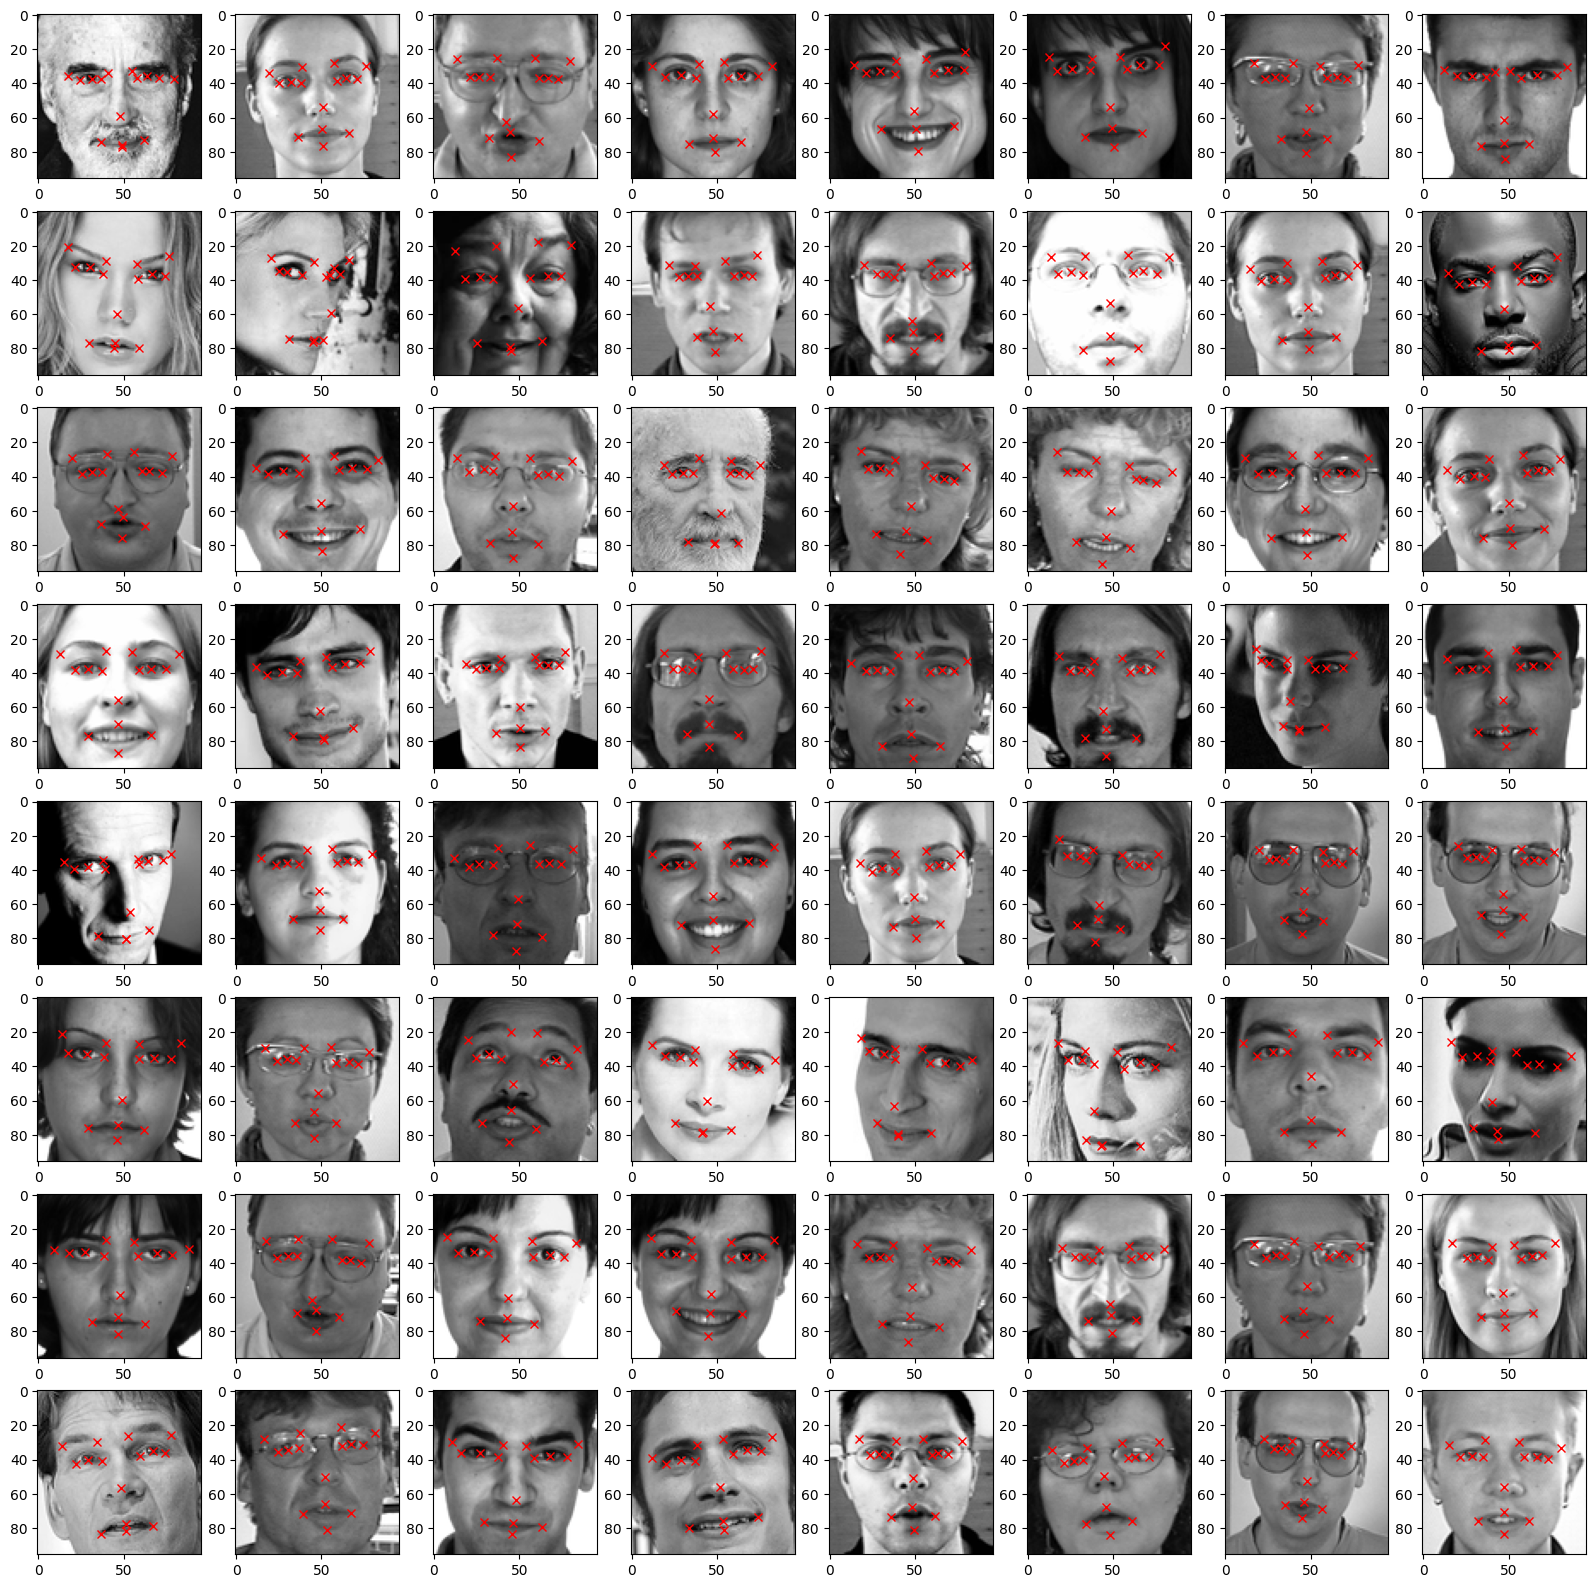

In [69]:
import random
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')
    

# TASK #4: PERFORM IMAGE AUGMENTATION

In [70]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [71]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [72]:
# Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

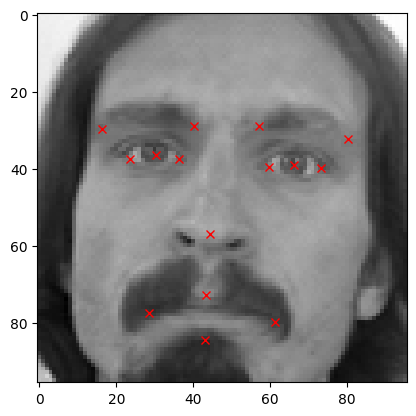

In [73]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

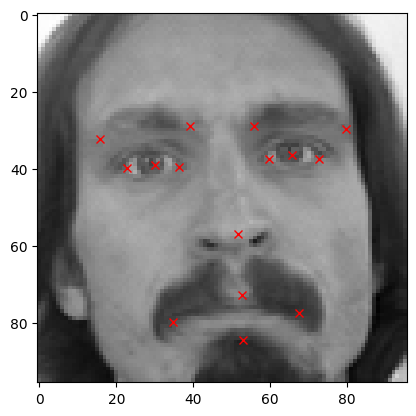

In [74]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [75]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [76]:
augmented_df.shape

(4280, 31)

In [77]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

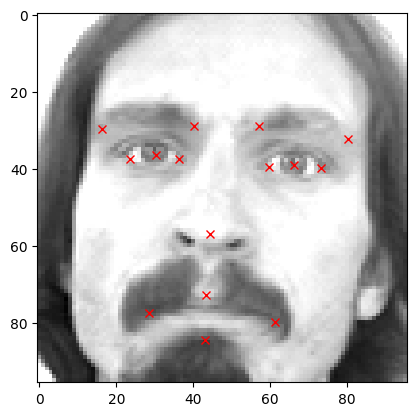

In [78]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [79]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [80]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

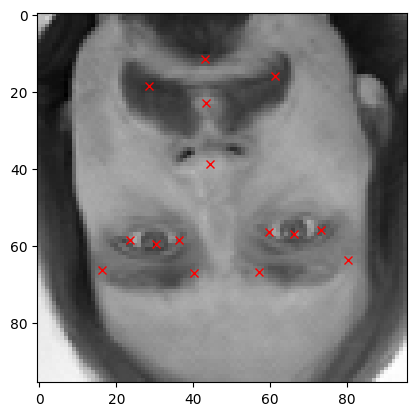

In [81]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

# TASK #5: PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION

In [82]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [83]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [84]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [85]:
X_train.shape

(5136, 96, 96, 1)

In [86]:
X_test.shape

(1284, 96, 96, 1)

### BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL 

In [32]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [33]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']              

MINI CHALLENGE #10:
- Experiment with changing the network architecture by removing 2 MaxPooling layers from the Res Block and train the model
- Try to add 'X = res_block(X, filter= [256,256,1024], stage= 4)' Block after stage #3 block. 
- What did you observe? Comment on your answer

Number of trainable parameters increase significantly

# TASK #10: COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [35]:
adam = optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, metrics = ['accuracy'])
# Check this out for more information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [36]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [37]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 16, epochs = 100, validation_split = 0.1, callbacks=[checkpointer])

Epoch 1/100
289/289 [==============================] - ETA: 0s - loss: 218.0081 - accuracy: 0.5580
Epoch 00001: val_loss improved from inf to 313.75757, saving model to FacialKeyPoints_weights.hdf5


C:\Users\Admin\miniconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


289/289 [==============================] - 16s 31ms/step - loss: 218.0081 - accuracy: 0.5580 - val_loss: 313.7576 - val_accuracy: 0.7471
Epoch 2/100
289/289 [==============================] - ETA: 0s - loss: 96.3168 - accuracy: 0.5958
Epoch 00002: val_loss improved from 313.75757 to 139.22023, saving model to FacialKeyPoints_weights.hdf5
289/289 [==============================] - 8s 29ms/step - loss: 96.3168 - accuracy: 0.5958 - val_loss: 139.2202 - val_accuracy: 0.7471
Epoch 3/100
287/289 [============================>.] - ETA: 0s - loss: 71.3782 - accuracy: 0.5923- ETA: 1s - loss: 70.712
Epoch 00003: val_loss improved from 139.22023 to 115.15838, saving model to FacialKeyPoints_weights.hdf5
289/289 [==============================] - 8s 29ms/step - loss: 71.2400 - accuracy: 0.5932 - val_loss: 115.1584 - val_accuracy: 0.7004
Epoch 4/100
289/289 [==============================] - ETA: 0s - loss: 56.2062 - accuracy: 0.5894
Epoch 00004: val_loss improved from 115.15838 to 84.70910, saving

287/289 [============================>.] - ETA: 0s - loss: 10.0966 - accuracy: 0.7162
Epoch 00056: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 24ms/step - loss: 10.1029 - accuracy: 0.7155 - val_loss: 62.4368 - val_accuracy: 0.7490
Epoch 57/100
289/289 [==============================] - ETA: 0s - loss: 7.9196 - accuracy: 0.7261
Epoch 00057: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 24ms/step - loss: 7.9196 - accuracy: 0.7261 - val_loss: 66.2998 - val_accuracy: 0.7471
Epoch 58/100
289/289 [==============================] - ETA: 0s - loss: 8.3822 - accuracy: 0.7280
Epoch 00058: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 24ms/step - loss: 8.3822 - accuracy: 0.7280 - val_loss: 60.6377 - val_accuracy: 0.7412
Epoch 59/100
289/289 [==============================] - ETA: 0s - loss: 8.3161 - accuracy: 0.7373
Epoch 00059: val_loss did not improve from 46.44471
289/289 [===

Epoch 85/100
289/289 [==============================] - ETA: 0s - loss: 7.5840 - accuracy: 0.7538
Epoch 00085: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 24ms/step - loss: 7.5840 - accuracy: 0.7538 - val_loss: 50.7971 - val_accuracy: 0.7665
Epoch 86/100
288/289 [============================>.] - ETA: 0s - loss: 8.4591 - accuracy: 0.7448
Epoch 00086: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 23ms/step - loss: 8.4494 - accuracy: 0.7451 - val_loss: 54.4191 - val_accuracy: 0.7938
Epoch 87/100
288/289 [============================>.] - ETA: 0s - loss: 6.8661 - accuracy: 0.7680
Epoch 00087: val_loss did not improve from 46.44471
289/289 [==============================] - 7s 24ms/step - loss: 6.8686 - accuracy: 0.7683 - val_loss: 55.3483 - val_accuracy: 0.7724
Epoch 88/100
289/289 [==============================] - ETA: 0s - loss: 6.4678 - accuracy: 0.7642
Epoch 00088: val_loss did not improve from 46.44471
2

In [38]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


### ASSESS TRAINED KEY FACIAL POINTS DETECTION MODEL PERFORMANCE

In [90]:
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
# best Weight weights_keypoint.hdf5 
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [91]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 1s 13ms/step - loss: 23.2347 - accuracy: 0.7227
Accuracy : 0.722741425037384


In [92]:
# Predict the Unseen Data and save as Dataframe
def predict(X_test):
    columns = keyfacial_df_copy.columns[:-1]
    # Making prediction from the keypoint model
    df_predict = model_1_facialKeyPoints.predict(X_test)
    # Converting the predictions into a dataframe
    df_predict = pd.DataFrame(df_predict, columns= columns)  
    return df_predict

df_predict = predict(X_test)

In [42]:
df_predict.head(2)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          27.880478          39.803345           67.435455   
1          61.735905          37.029106           35.056938   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.911873                35.531036                40.226635   
1           36.373611                56.573345                37.185699   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                19.233643                40.616043                 59.277027   
1                67.181236                37.822674                 39.816696   

   right_eye_inner_corner_y  ...  nose_tip_x  nose_tip_y  mouth_left_corner_x  \
0                 38.616920  ...   49.298752   59.128422            33.725178   
1                 36.290478  ...   45.938789   56.952484            59.225269   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            78.989410             67.968300             76.871254   
1            69.484787             37.525993             68.533638   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               50.472015               74.903923                  51.140385   
1               47.589611               66.747711                  47.805077   

   mouth_center_bottom_lip_y  
0                  86.013344  
1                  76.081474  

[2 rows x 30 columns]

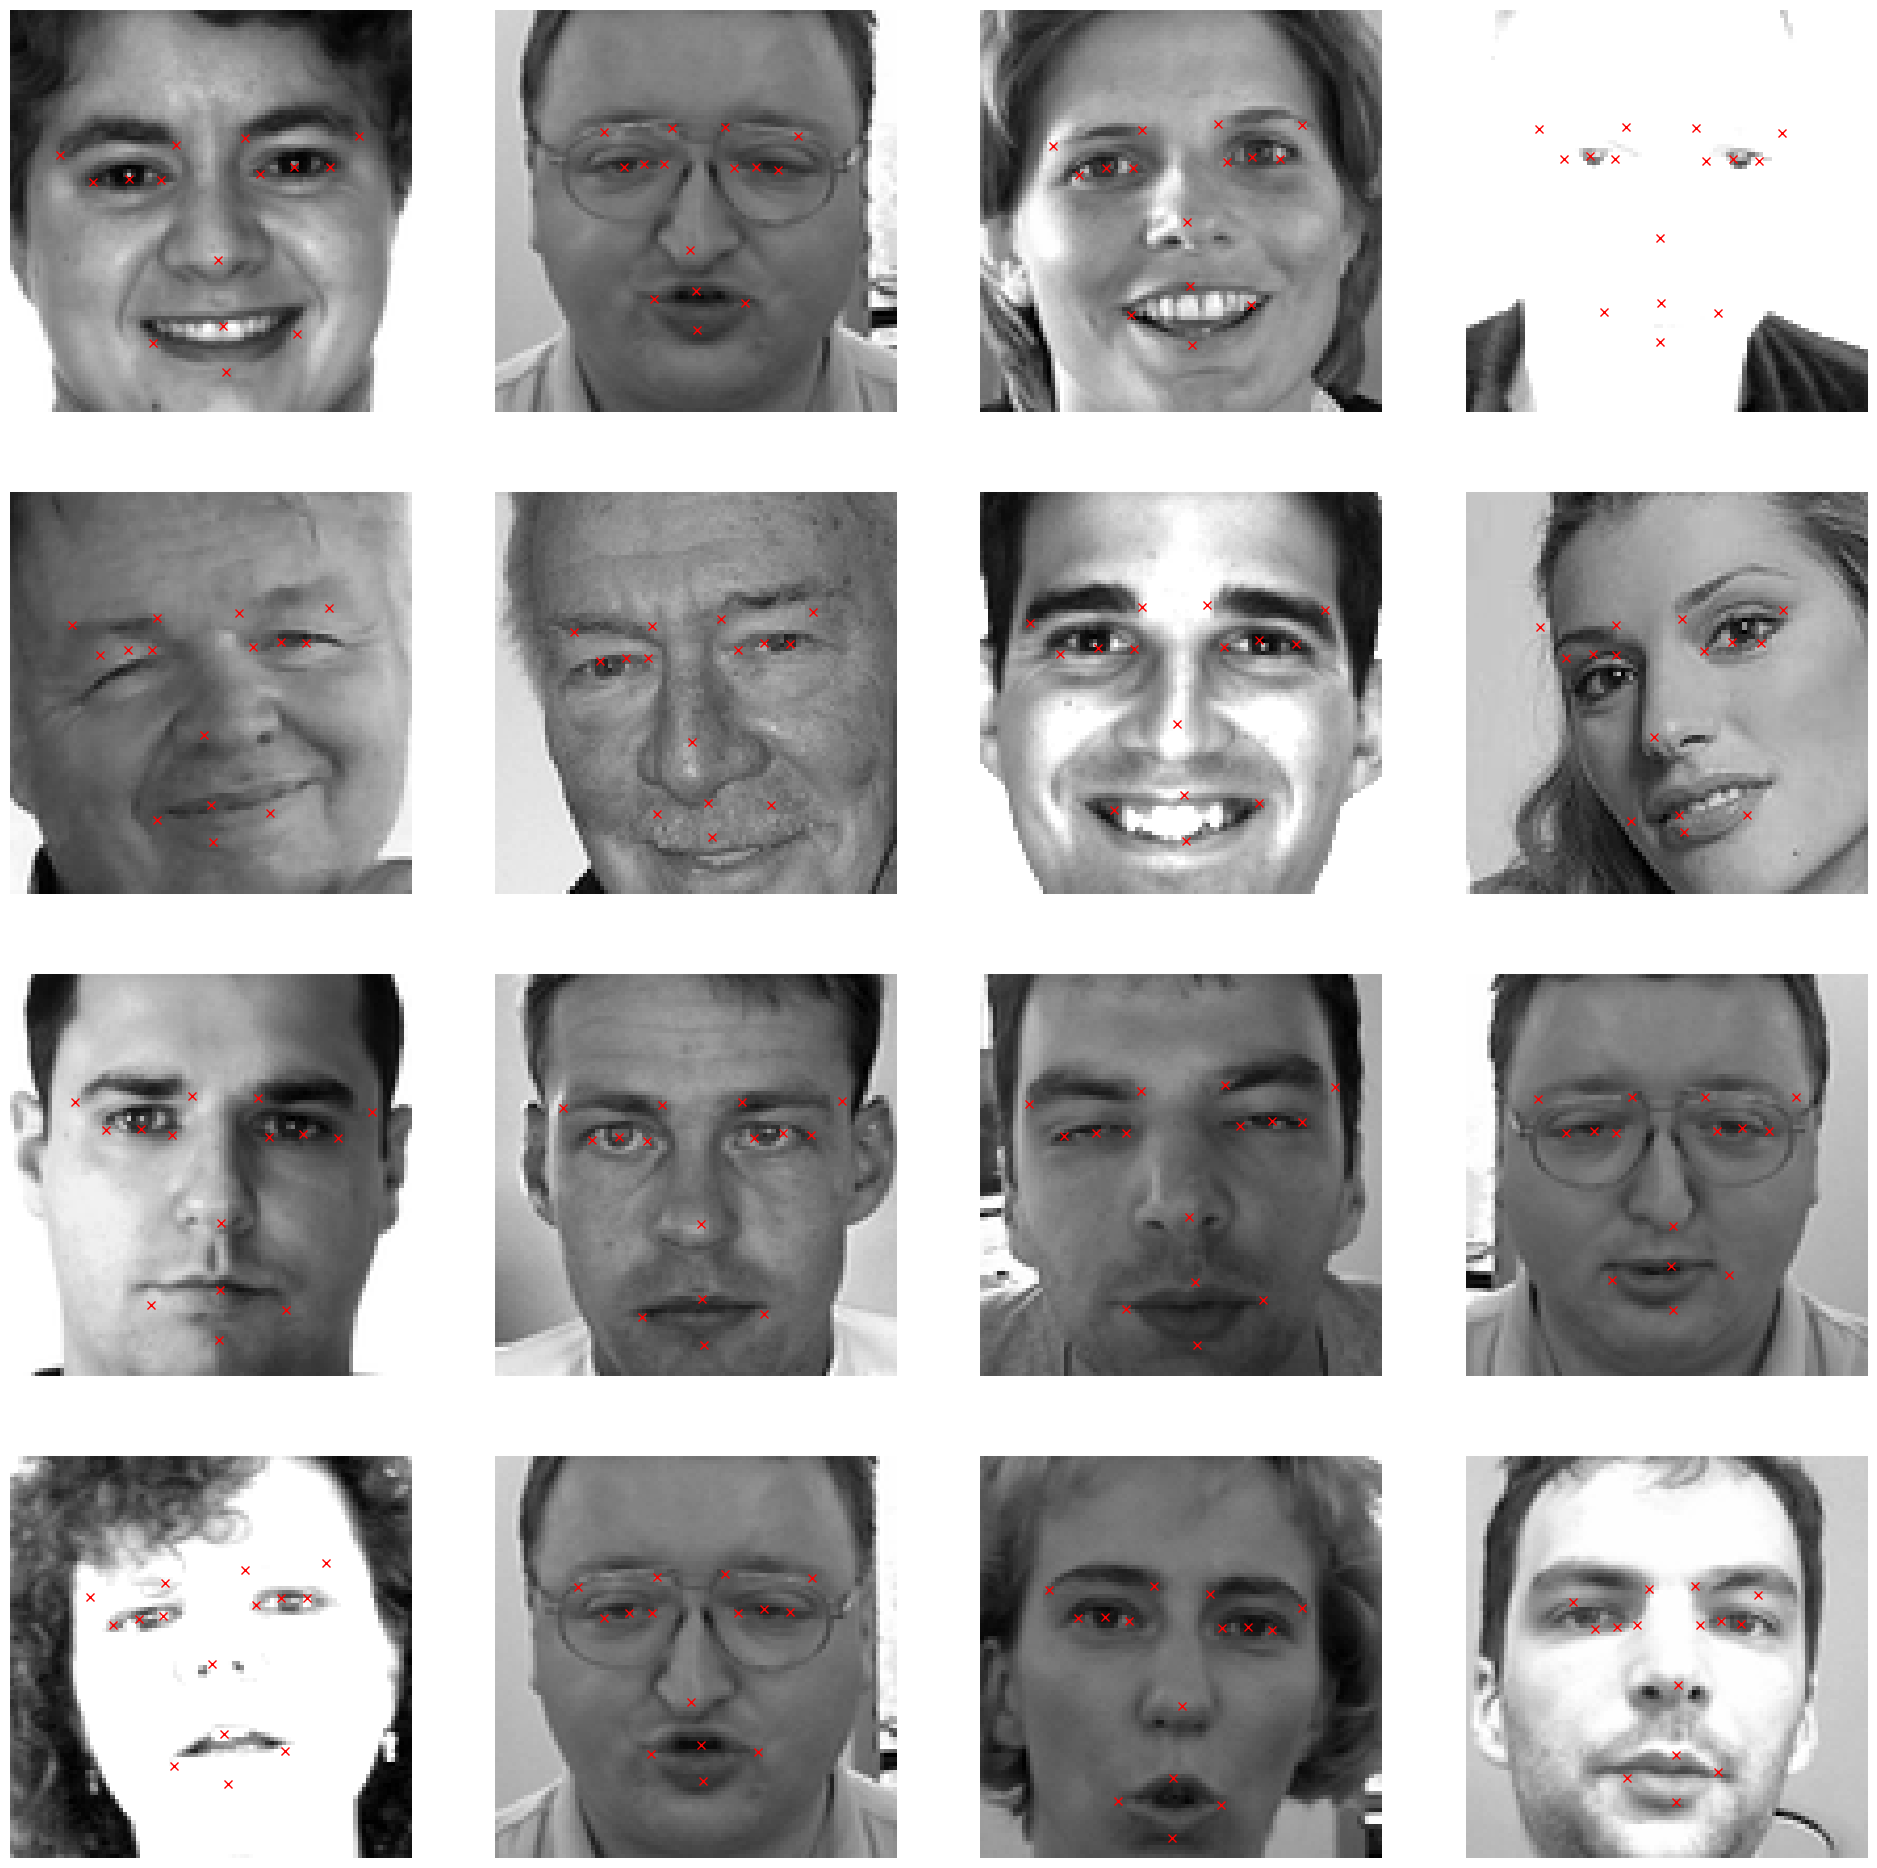

In [43]:
# Plotting the test images and their predicted keypoints

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    #axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

In [44]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

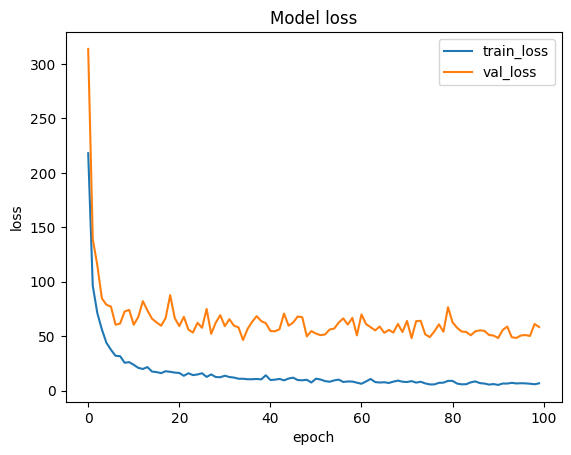

In [45]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# PART 2. FACIAL EXPRESSION DETECTION

### IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION

In [3]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [4]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [5]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [6]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [7]:
# Resize images from (48, 48) to (96, 96)

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [8]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [9]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [10]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [11]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [12]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [13]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

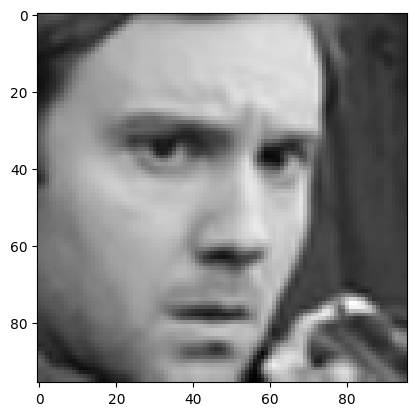

In [14]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

### VISUALIZE IMAGES AND PLOT LABELS

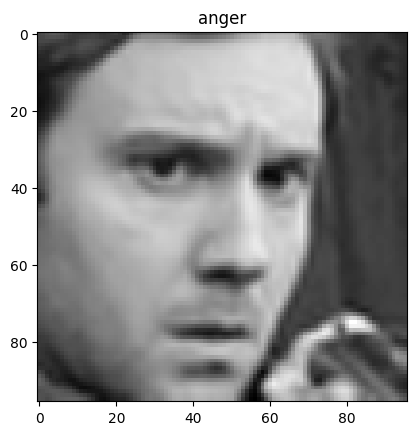

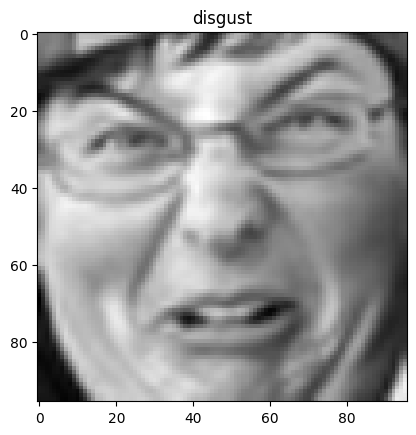

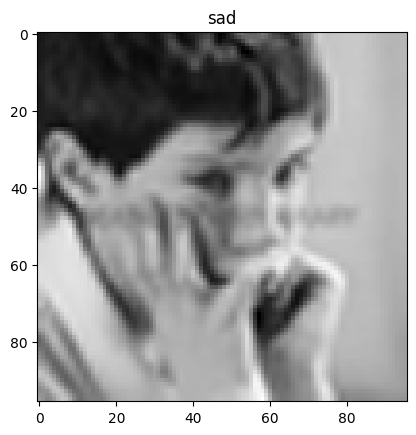

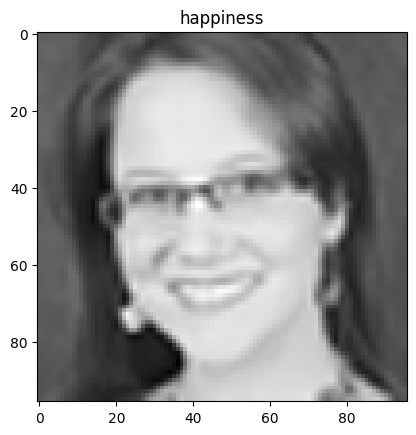

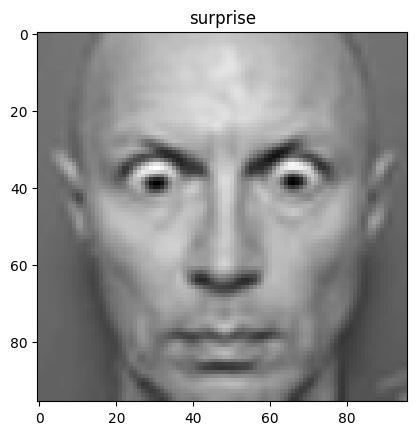

In [15]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
    img = data[' pixels'].item()
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap = 'gray')

In [16]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [17]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

<AxesSubplot: ylabel='emotion'>

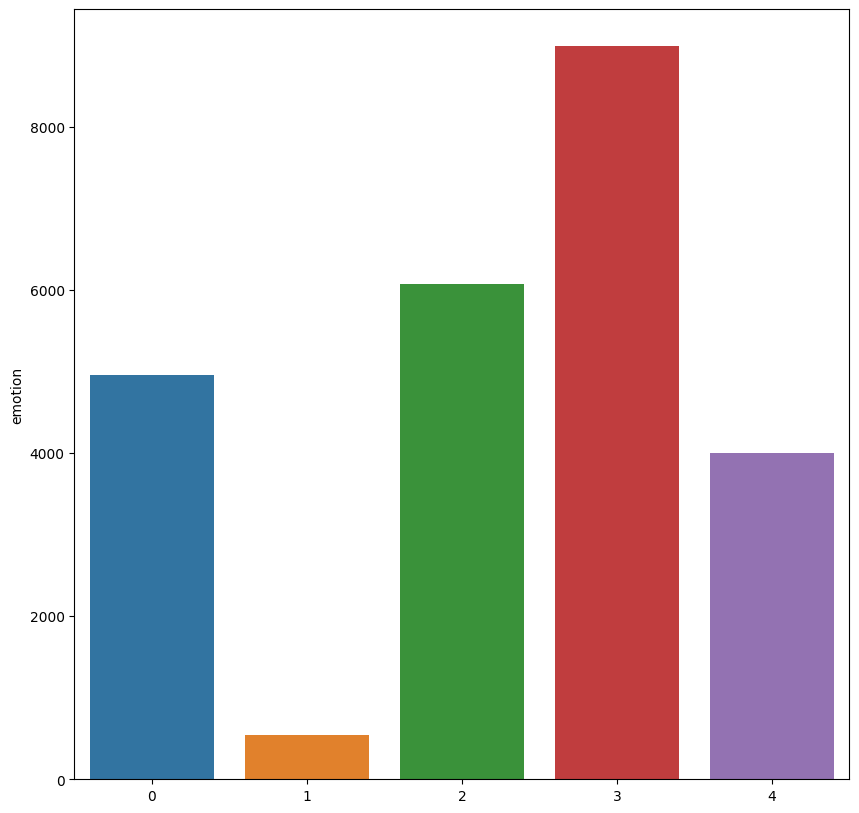

In [18]:
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

### PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [22]:
# split the dataframe in to features and labels
from tensorflow.keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [23]:

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [24]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [25]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [26]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [27]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [28]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [29]:
X_train

array([[[[ 0.3880456 ],
         [ 0.4878211 ],
         [ 0.6527795 ],
         ...,
         [ 0.8532069 ],
         [ 0.94982195],
         [ 1.0120482 ]],

        [[ 0.43101805],
         [ 0.5093945 ],
         [ 0.63918424],
         ...,
         [ 0.8335399 ],
         [ 0.94671154],
         [ 1.0187931 ]],

        [[ 0.5053484 ],
         [ 0.5485238 ],
         [ 0.62047756],
         ...,
         [ 0.8022626 ],
         [ 0.94192684],
         [ 1.0297894 ]],

        ...,

        [[ 0.0626016 ],
         [ 0.0645141 ],
         [ 0.05778001],
         ...,
         [ 0.9576436 ],
         [ 0.95952857],
         [ 0.960673  ]],

        [[-0.00558089],
         [ 0.04269116],
         [ 0.11300091],
         ...,
         [ 0.95709527],
         [ 0.95765656],
         [ 0.95799726]],

        [[-0.05255504],
         [ 0.02401656],
         [ 0.14128365],
         ...,
         [ 0.95676905],
         [ 0.95654285],
         [ 0.9564055 ]]],


       [[[ 0.01609988],


In [30]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


### BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [34]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']           

In [35]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [36]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [37]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
345/345 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.4817
Epoch 00001: val_loss improved from inf to 1.73287, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 13s 22ms/step - loss: 1.2473 - accuracy: 0.4817 - val_loss: 1.7329 - val_accuracy: 0.2622
Epoch 2/100
  1/345 [..............................] - ETA: 12s - loss: 1.0297 - accuracy: 0.5000

C:\Users\Admin\miniconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


343/345 [============================>.] - ETA: 0s - loss: 0.9219 - accuracy: 0.6316
Epoch 00002: val_loss improved from 1.73287 to 1.17539, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 7s 19ms/step - loss: 0.9217 - accuracy: 0.6318 - val_loss: 1.1754 - val_accuracy: 0.5309
Epoch 3/100
343/345 [============================>.] - ETA: 0s - loss: 0.8135 - accuracy: 0.6836
Epoch 00003: val_loss did not improve from 1.17539
345/345 [==============================] - 7s 19ms/step - loss: 0.8136 - accuracy: 0.6835 - val_loss: 1.9450 - val_accuracy: 0.3428
Epoch 4/100
344/345 [============================>.] - ETA: 0s - loss: 0.7609 - accuracy: 0.7061
Epoch 00004: val_loss improved from 1.17539 to 0.95539, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 7s 19ms/step - loss: 0.7606 - accuracy: 0.7063 - val_loss: 0.9554 - val_accuracy: 0.6409
Epoch 5/100
343/345 [============================>.] - ETA: 0s - loss:

Epoch 30/100
344/345 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8406
Epoch 00030: val_loss did not improve from 0.59681
345/345 [==============================] - 6s 19ms/step - loss: 0.4264 - accuracy: 0.8404 - val_loss: 0.6900 - val_accuracy: 0.7484
Epoch 31/100
343/345 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8375
Epoch 00031: val_loss did not improve from 0.59681
345/345 [==============================] - 7s 19ms/step - loss: 0.4229 - accuracy: 0.8378 - val_loss: 0.6488 - val_accuracy: 0.7671
Epoch 32/100
344/345 [============================>.] - ETA: 0s - loss: 0.4142 - accuracy: 0.8389
Epoch 00032: val_loss did not improve from 0.59681
345/345 [==============================] - 7s 19ms/step - loss: 0.4143 - accuracy: 0.8388 - val_loss: 0.8245 - val_accuracy: 0.6971
Epoch 33/100
343/345 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8448
Epoch 00033: val_loss did not improve from 0.59681
345/345 

In [38]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

### ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [39]:
with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [40]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 7ms/step - loss: 0.3385 - accuracy: 0.8617
Test Accuracy: 0.8616761565208435


In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

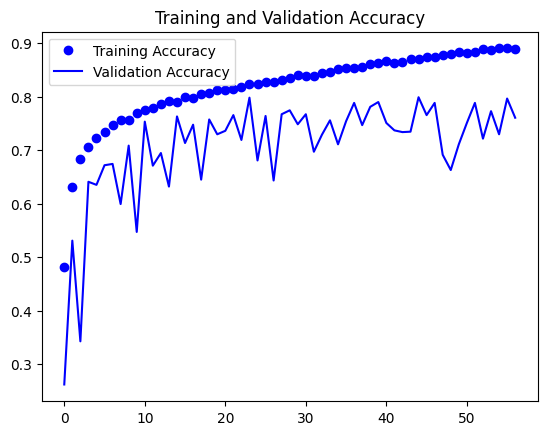

In [43]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

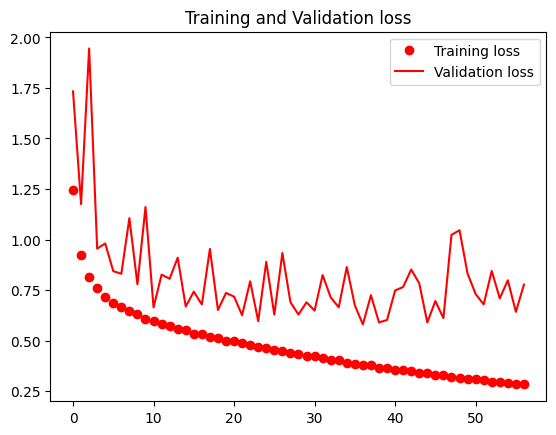

In [44]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [45]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [46]:
y_true.shape

(1229,)

<AxesSubplot: >

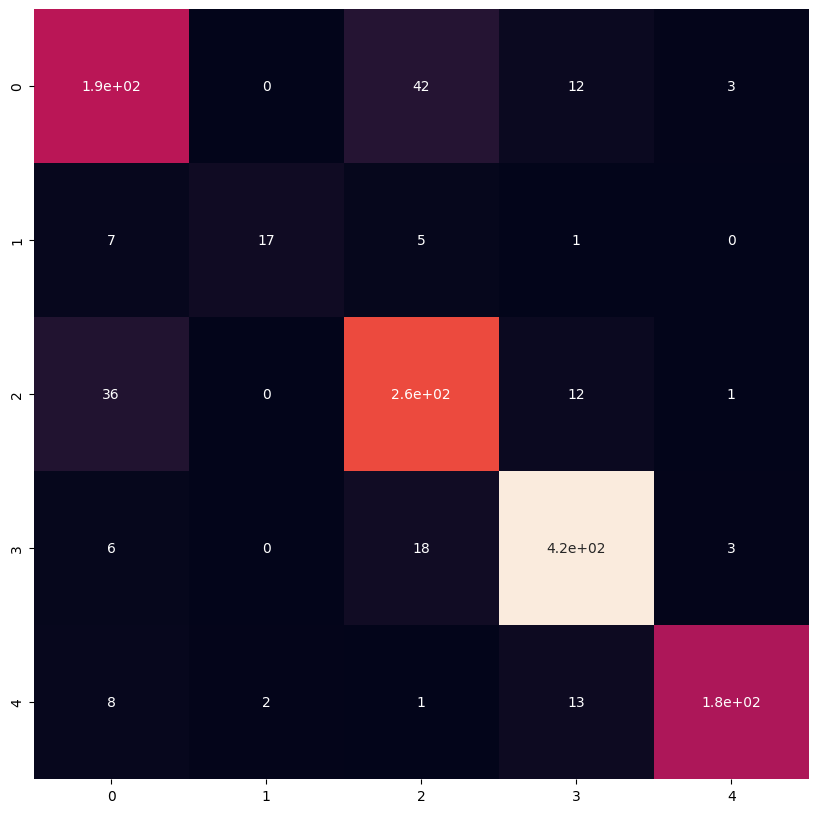

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

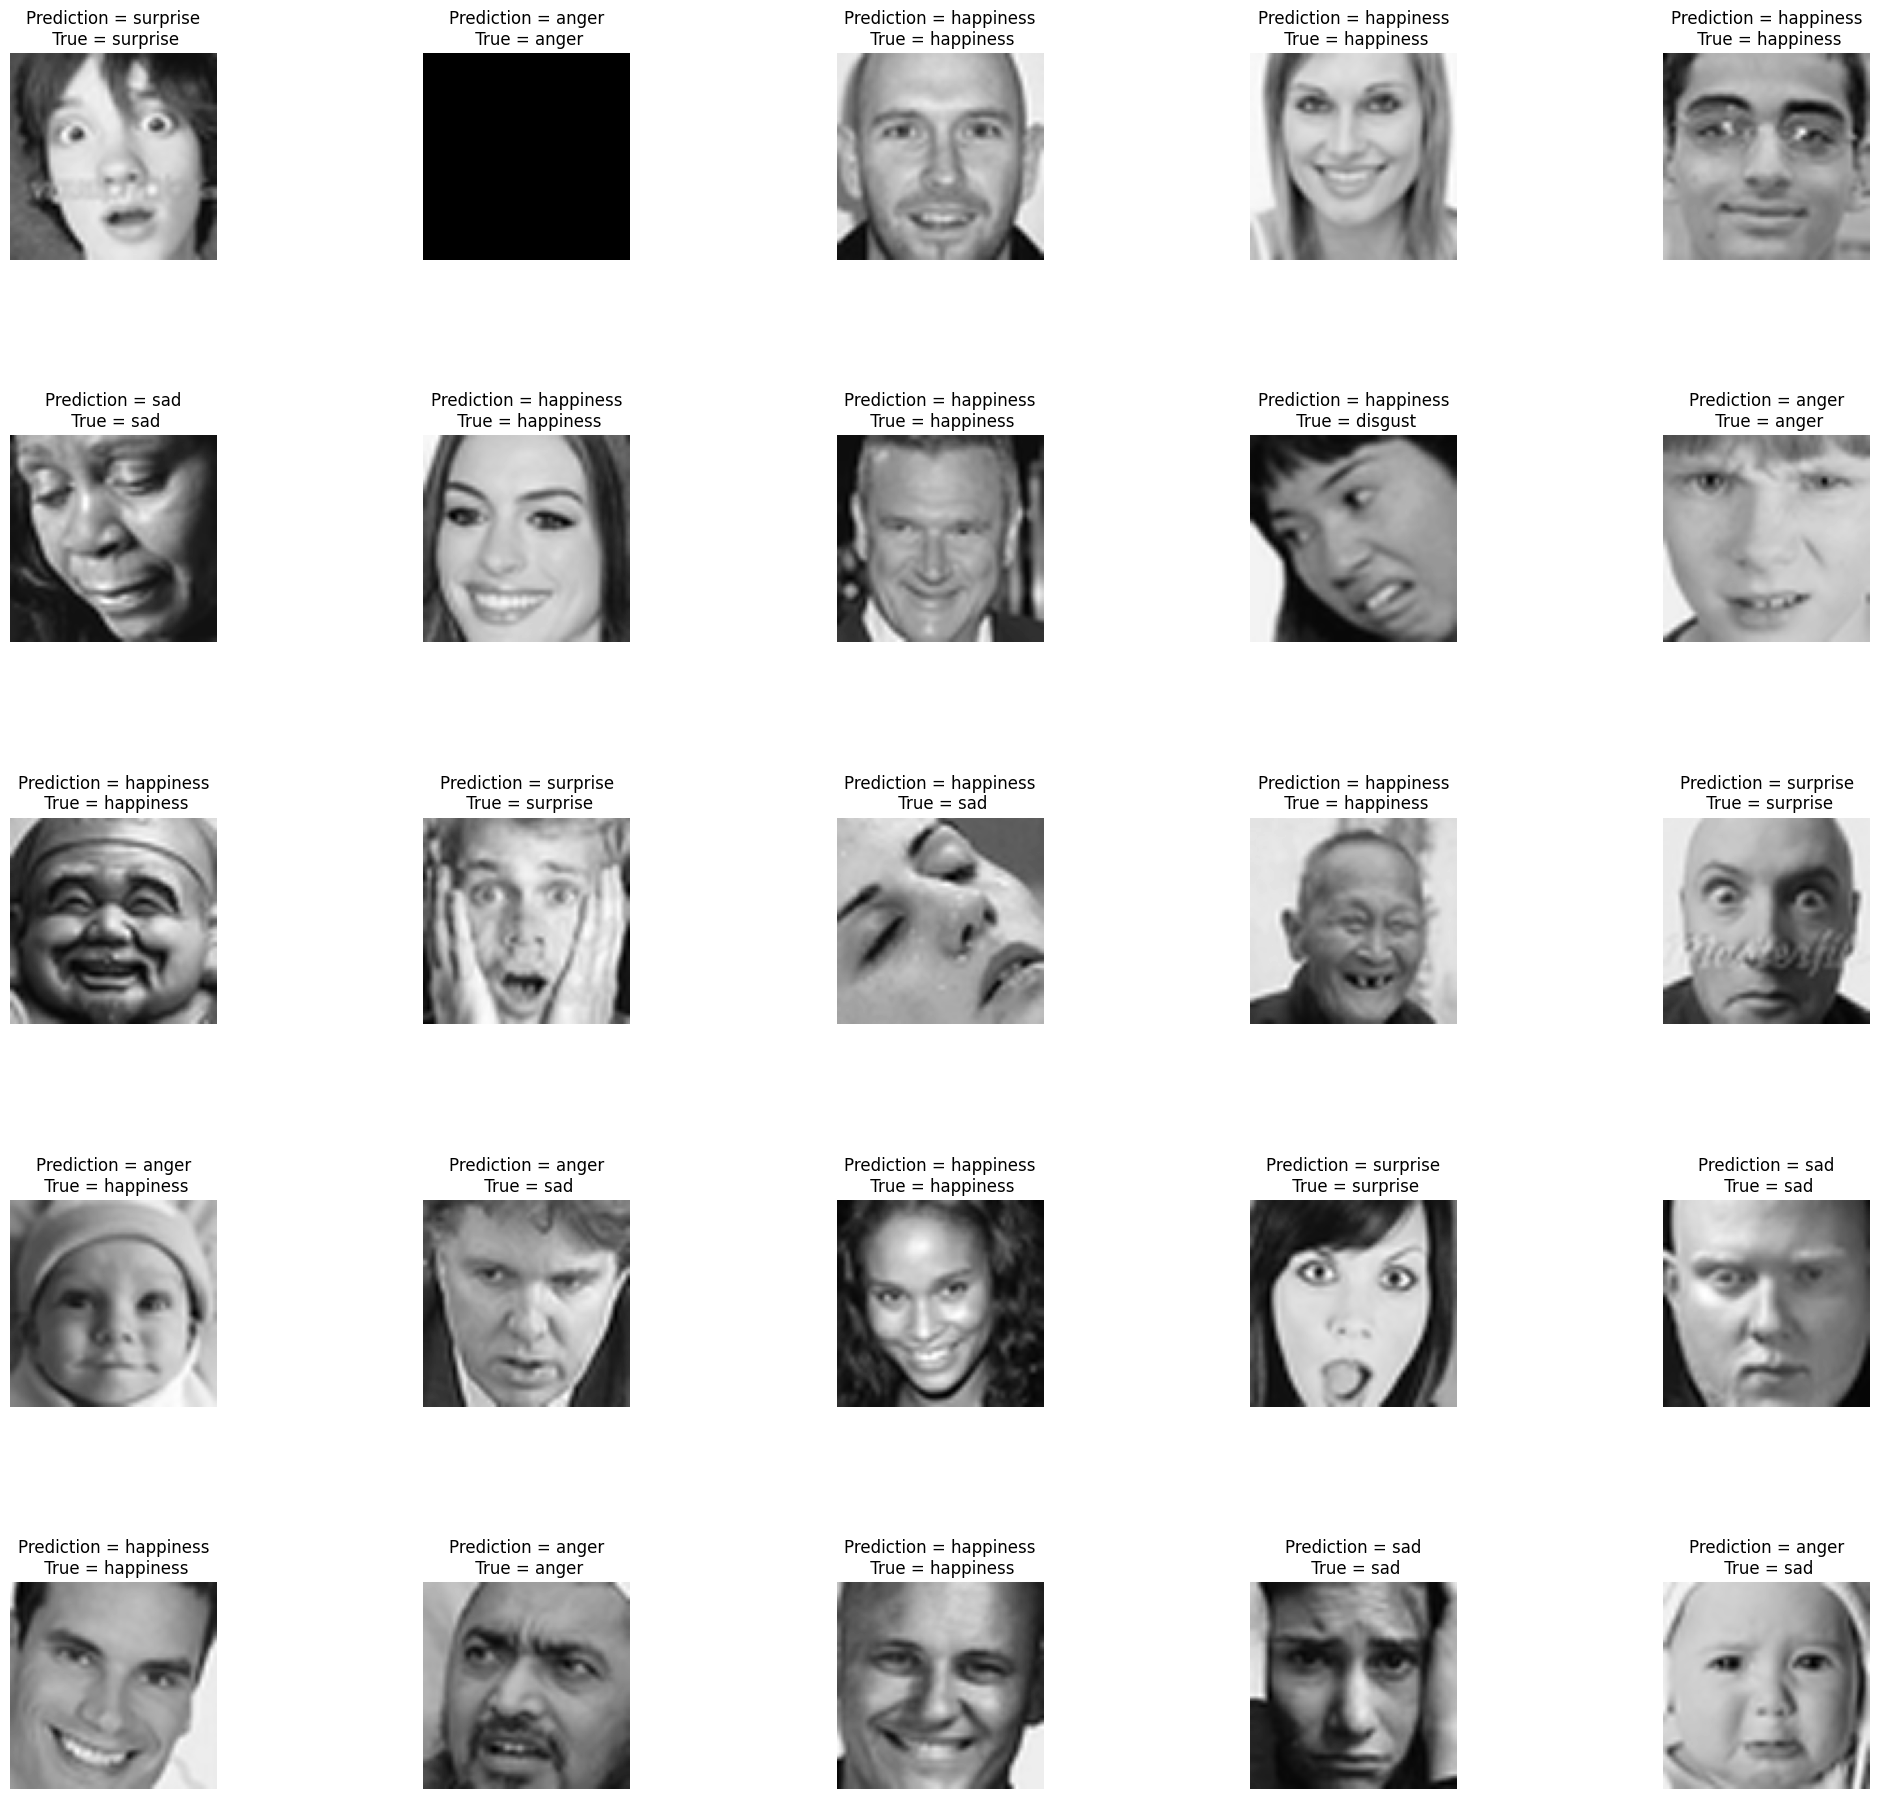

In [50]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       248
           1       0.89      0.57      0.69        30
           2       0.80      0.84      0.82       308
           3       0.92      0.94      0.93       442
           4       0.96      0.88      0.92       201

    accuracy                           0.86      1229
   macro avg       0.87      0.80      0.83      1229
weighted avg       0.86      0.86      0.86      1229



In [52]:
# PART 3. COMBINE BOTH FACIAL EXPRESSION AND KEY POINTS DETECTION MODELS

In [93]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [94]:
df_predict = predict(X_test)

In [95]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          64.011864          36.442875           29.298338   
1          64.709572          35.569012           29.761232   
2          29.846413          36.102085           63.956295   
3          63.412712          37.571819           31.643059   
4          65.913147          33.262177           28.629475   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           39.107613                57.859207                37.489639   
1           37.905621                58.691742                36.911381   
2           32.760460                35.110298                35.857204   
3           35.873562                57.599960                37.747326   
4           34.517757                57.704533                35.291969   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                70.173485                36.674698                 35.656090   
1                71.113930                35.803623                 36.099701   
2                23.918646                36.714645                 58.758057   
3                69.668892                38.644230                 36.807671   
4                73.953384                33.727642                 36.241165   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 38.579514  ...   50.281273            63.410526   
1                 38.039959  ...   52.487812            64.825508   
2                 34.236885  ...   54.007763            37.833694   
3                 36.427734  ...   58.649590            59.102528   
4                 35.688740  ...   59.810040            64.748787   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            70.817619             35.233295             73.136337   
1            74.062828             37.735790             76.580566   
2            68.683861             63.759159             65.155457   
3            69.947998             34.332367             68.123505   
4            73.597687             32.842907             74.993782   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               49.143612               65.468224                  49.710190   
1               50.593742               70.670929                  51.081032   
2               50.824394               63.711590                  51.702946   
3               45.986778               67.916275                  45.966476   
4               48.131966               76.253845                  48.344269   

   mouth_center_bottom_lip_y  emotion  
0                  79.262985        2  
1                  81.414223        2  
2                  74.749115        0  
3                  75.737366        2  
4                  80.529152        0  

[5 rows x 31 columns]

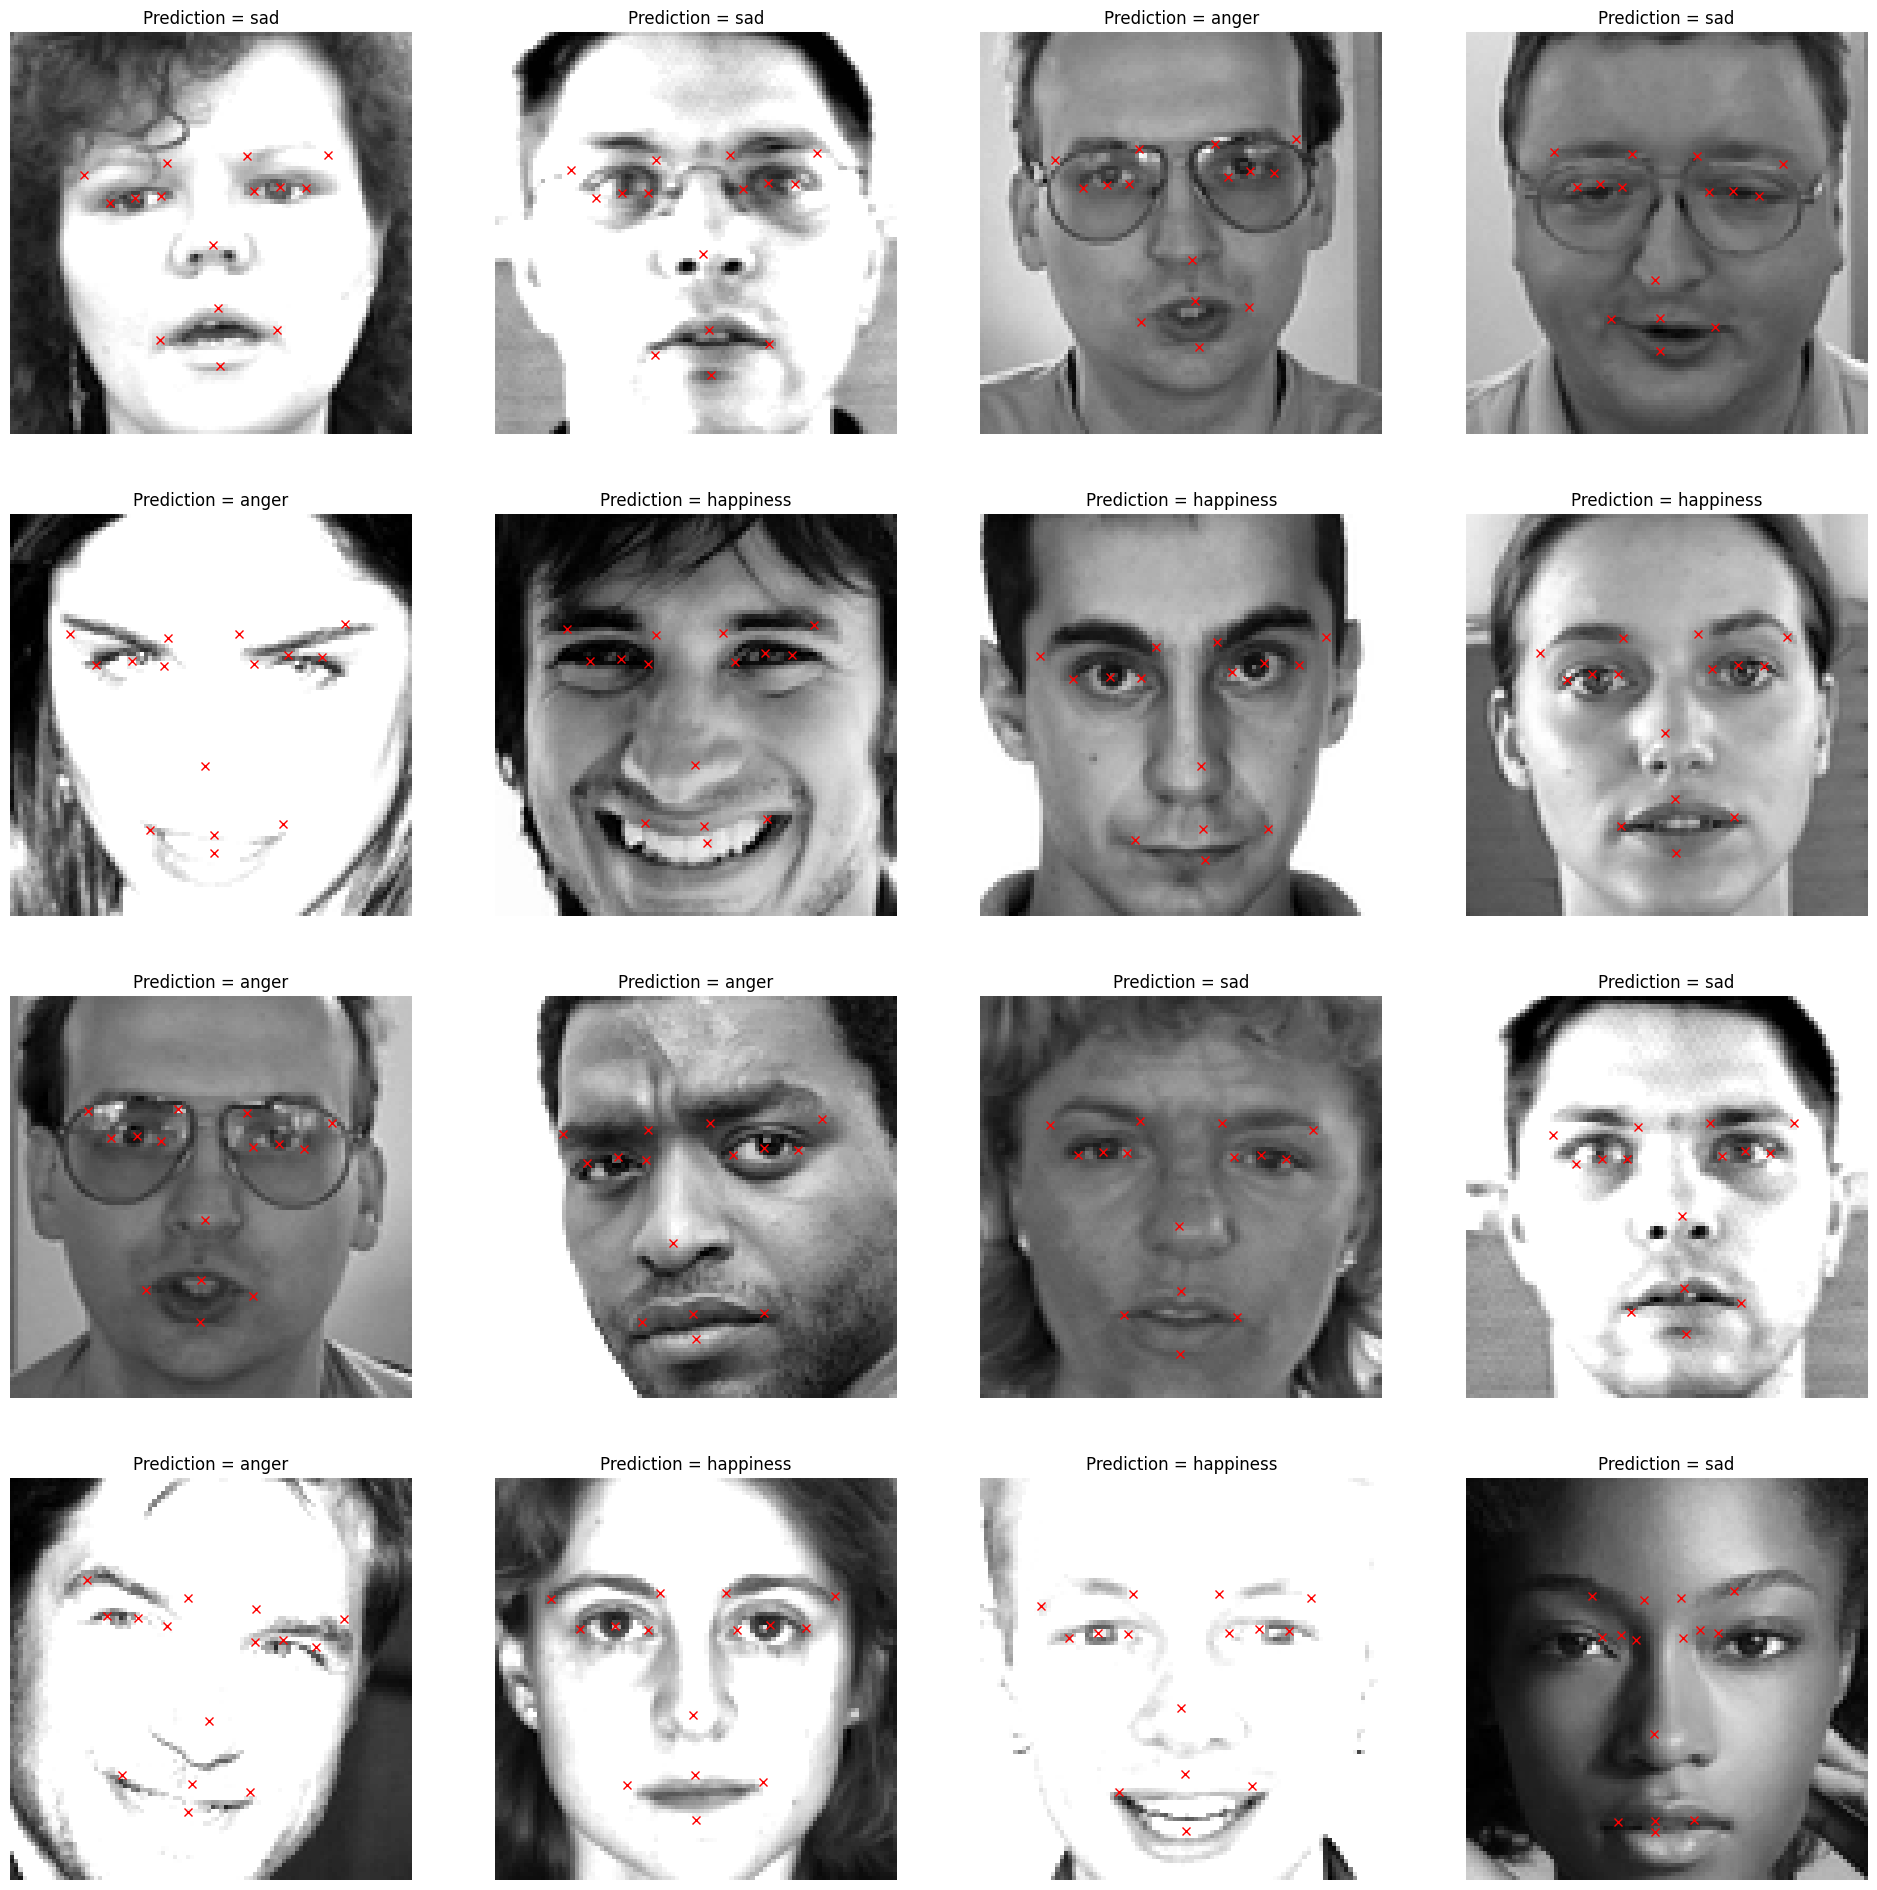

In [96]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            